# Kaggle Titanic EDA
From [Kaggle competition](https://www.kaggle.com/c/titanic). The goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

**Data dictionary**

Variable | Definition | Key | Notes
:--- | :--- | :--- | :---
Survival | Did passenger survive shipwreck | 0=No, 1=Yes | 
Pclass | Ticket class | 1=1st, 2=2nd, 3=3rd | 1st=Upper class, 2nd=Middle class, 3rd=Lower class
Sex | Male or female |  | 
Age | Age in year of shipwreck |  | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
SibSp | # of siblings/spouses abord the Titanic | | Sibling = brother, sister, stepbrother, stepsister. Spouse = husband, wife (mistresses and fiancés were ignored)
Parch | # of parents/children abord the Titanic | | Parent = mother, father. Child = daughter, son, stepdaughter, stepson
Ticket | Ticket number | |
Fare | Passenger fare | |
Cabin | Cabin # | |
Embarked | Port of embarkation | C=Cherbourg, Q=Queenstown, S=Southampton |

**Assumption**

Since this is true historical event happened in 1912, we can make some assumption based on the culture/environment in 1912, historical evidence, survivors' stories, etc.
1. Women and children first: the courtesy of English gentlemans should lead to higher female passengers survival rate. Children should also have higher survival rate only if someone is available to help them, it's less likely that a 10 year-old can go to boat deck by himself/herself in chaos. Thus children's survival strongly depends on whether their guardians/family/nanny have the advantage to move through crowd and be saved/spotted


2. Class privilege: the social class is a critical feature because of geographic reasons. Passengers in upper class cabins were mostly in upper deck, which is closest to boat deck, and middle class cabins were in middle deck, and lower class were in lower deck.


3. Cabin: notice that the shipwreck happened in midnight, assuming most people were in their cabin and rely on crews knocking on doors to notice the impact. The higher decks are likely to be noticed first. And because the only authoritative source of cabin data is the incomplete first class passenger list recovered with the body of steward, people with cabin number in this dataset are mostly first class passengers.


4. Fare and class: probably have high correlation: 
    - expensive ticket = upper class cabin = higher survival rate
    - cheaper ticket = lower class cabin = lower survival rate


5. Embarkation: might not be so relevant to survival. It doesn't make sense to save people embarked from certain location.

**Models**

This project looks at 3 types of models: 
1. Classification models
2. Ensemble models
3. XGBoost model


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

## Load Data
The compatition provided training and testing set. The target is Survived column.

In [2]:
train_df = pd.read_csv("train.csv", header=0, index_col=0)
test_df = pd.read_csv("test.csv", header=0, index_col=0)

In [3]:
print(train_df.info())
display(train_df.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [4]:
print(test_df.info())
display(test_df.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C


In [5]:
train = train_df.copy(deep=True)
test = test_df.copy(deep=True)

### Baseline Model and Accuracy
Performs minimal data cleaning then testing without any EDA or feature engineering, and pick one algorithm as our baseline model and its accuracy as our baseline metric.

#### Data wrangling
1. Drop complicated string features
2. Convert categorical features to numerical
3. Data imputation

In [6]:
# Drop complicated string features
dummy_X = train.drop(columns=['Name', 'Cabin', 'Ticket', 'Survived'])

# Convert categorical features to numerical
dummy_X.Sex = (dummy_X.Sex == 'female').astype(int)
dummy_X.Embarked.ffill(axis=0, inplace=True)
dummy_X.Embarked = LabelEncoder().fit_transform(dummy_X.Embarked.values)

# Data imputation
dummy_X.fillna(dummy_X.mean(), inplace=True)

dummy_y = train.Survived

#### Train baseline model

In [7]:
# train model
model = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(model, dummy_X, dummy_y, cv=cv, scoring='balanced_accuracy')
print("%s:\tacc=%.3f" % (model, -1.0 * np.mean(scores)))

# print feature importances
model.fit(dummy_X, dummy_y)
print("Feature Importances:")
feature_importance = model.feature_importances_
index = dummy_X.columns
for i in range(len(feature_importance)):
    print("%s\t%.6f" % (index[i], feature_importance[i]))

GradientBoostingClassifier():	acc=-0.811
Feature Importances:
Pclass	0.150324
Sex	0.480315
Age	0.124380
SibSp	0.057103
Parch	0.002440
Fare	0.165223
Embarked	0.020215


According to feature importance, **Sex** has most impact on prediction, then **Fare**, **Pclass**, and **Age**, and the least important features are **SibSp**, **Embarked**, and **Parch**. We should pay extra attention on the important features individually. As for least important features we can merge or segment them to strengthen the link with target, or simply drop them to offload the training effort in model.

## EDA

### Sex
Based on survivor's story, the officers observed the “women and children first” rule so aggressively that some empty boats were let go into the water rather than let any men occupy them, making Sex one of the critical features. 

Convert to numericals using binary encoder: male=0, female=1

In [8]:
# Encode Sex: Men = 0, Female = 1
train.Sex = (train.Sex == 'female').astype(int)
test.Sex = (test.Sex == 'female').astype(int)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Sex, dtype: object

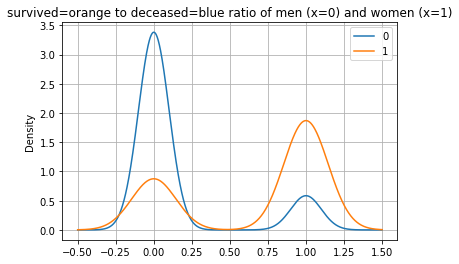

In [9]:
# Plot survived=1 to deceased=0 ratio of men/women
train.groupby(['Survived']).Sex.plot.density(legend=True, grid=True, title="survived=orange to deceased=blue ratio of men (x=0) and women (x=1)")
# x axis = Sex
# men: x=0
# women: x=1
# blue: deceased density
# orange: survived density

In [10]:
# Survival rate
train.groupby(['Sex']).Survived.describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
0,577.0,0.188908,0.391775,0.0,0.0,0.0,0.0,1.0
1,314.0,0.742038,0.438211,0.0,0.0,1.0,1.0,1.0


As expected, women (Sex=1) has much higher rate of survival. Later we'll look at group statistics of how Sex correlates with other features.

### Pclass
The nobles, upper class or social elites are more likely to stay in first class cabins. This is also crucial key because not only first class cabins were closer to boat deck, the British nobles or elites (especially men)  have responsibility to protect people and bring order, thus they have more say in who gets to be on the boat. There are pros and cons of the hierarchy:
- Upper class and officers strictly conduct "wonmen and children first" policy
- Upper class have privilage to occupy seats on boat than lower class

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Pclass, dtype: object

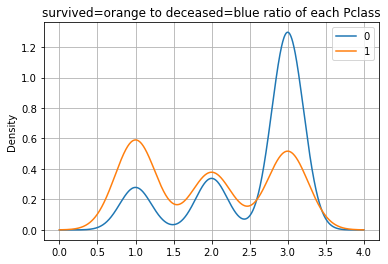

In [11]:
# Plot survived=1 to deceased=0 ratio of 1st/2nd/3rd class
train.groupby(['Survived']).Pclass.plot.density(legend=True, grid=True, title="survived=orange to deceased=blue ratio of each Pclass")
# x axis = Pclass
# 1st class: x=1
# 2nd class: x=2
# 3rd class: x=3
# blue: deceased density
# orange: survived density

In [12]:
# Survival rate
train.groupby(['Pclass']).Survived.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,0.629630,0.484026,0.0,0.0,1.0,1.0,1.0
2,184.0,0.472826,0.500623,0.0,0.0,0.0,1.0,1.0
3,491.0,0.242363,0.428949,0.0,0.0,0.0,0.0,1.0


In [13]:
# Survived passengers of each class
train[train.Survived == 1].Pclass.value_counts()

1    136
3    119
2     87
Name: Pclass, dtype: int64

As expected, the rate of survival is 1st class > 2nd class and 3rd class. Notice that 2nd class has least number of passengers and least number of survived passengers. Later we'll look at how Pclass correlates with other features.

### Name
Here are some useful information from Name:
- Title: a person's title is an indication of their age, social class, marital status, military rank, clergyman, and more. For example,
    - Master.: an English honorific for boys and underaged men
    - Miss., Ms. and Mlle.: honorific for unmarried women. In 1900s, in average women usually get married around 22, so I assume most women addressed by Miss., Ms. and Mlle. are in their early 20s or younger.
    - Mrs., Mme.: addressing married women in general. As discussed, I assume most women addressed by Mrs. and Mme. are in their early 20s or younger.
    - Lady., Countess.: honorific for woman or wife of men with elite status.
    - Capt., Col., Major.: military personnel have higher change to self-sacrifice for the safety of others
    - Rev.: the Reverend is a courtesy title used when addressing a Christian cleric such as a pastor or priest
    - Dr.: medical practitioners, not just holders of a doctorate
    - Jonkheer., Sir., Don.: honorific for the nobles
    - Mr.: title for men in general


- Size of family/group: usually identified by passenger's last name, SibSp, and ParCh. One can also identify a group of passengers by their ticket number and fare. For example:
    - Family members have same last name and are included in SibSp and ParCh
    - Family friends, companions, servants, or nannies traveling with a family usually have same ticket number, fare, and maybe cabin as the family
    - Friends, partners, or colleagues traveling together usually have same ticket number, fare, and maybe cabin 
    
    Passengers travel together for various reasons, thus makes it difficult to identify family/group members and size solely by last name. In addition, last name in training set isn't categorical nor consistent with test set, hence not helpful.

In [14]:
# Extract person's title from Name
def ExtractTitle(df):
    titles = []
    for name in df.Name.str.split():
        for subs in name:
            if subs[-1] == ".":
                titles.append(subs[:-1])
                break
    df['Title'] = titles
    df['TitleEncode'] = LabelEncoder().fit_transform(df.Title)

ExtractTitle(test)
ExtractTitle(train)

In [15]:
# Survival rate of each title
train.groupby(['Title']).Survived.describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Capt,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Col,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0
Countess,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
Don,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Dr,7.0,0.428571,0.534522,0.0,0.00,0.0,1.00,1.0
Jonkheer,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Lady,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
Major,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0
Master,40.0,0.575000,0.500641,0.0,0.00,1.0,1.00,1.0


Majority people have title Mr., Mrs., Miss., and Master.. It's expected that more than half of training set have title Mr. since men vs. women in training set is 5:3.
#### Feature Engineering
Since title indicates a person's sex and status, it raises the question: does any (group of) title have higher chance to be saved? Try grouping and ranking titles based on pros and cons:
- Lady., Countess.: title of nobility
    - Pros: 
        - Being a women and benefit from "women and children first" policy
        - Having upper class privilege
        - Extra help from spouse, nobles, and officers.
- Mrs., Mme.: married women
    - Pros: 
        - "women and children first" policy
        - Help from spouse
- Master.: boy or young men
    - Pros:
        - "women and children first" policy
    - Cons:
        - Being underage and heavily dependent on parents
- Miss., Mlle., Ms.: unmarried women
    - Pros:
        - "women and children first" policy
    - Cons:
        - Heavily dependent on parents if she's underaged
- Mr., Dr., Sir., Jonkheer., Don.: men or male nobles
    - Cons:
        - "women and children first" policy
        - British etiquette dictates that British nobles should protect others first before themselves
        - Men tends to save spouse and children first before themselves
- Major., Col., Capt., Rev.: military and religious personnel
    - Cons:
        - "women and children first" policy
        - Military personnels have responsibility to protect others first before themselves
        - Men tends to save women and children first

In [16]:
def GroupTitle(df):
    titleDict = {'Lady':1, 'Countess':1,
                 'Mrs':2, 'Mme':2,
                 'Master':3,
                 'Miss':4, 'Mlle':4, 'Ms':4,
                 'Mr':5, 'Dr':5, 'Sir':5, 'Jonkheer':5, 'Don':5, 
                 'Major':6, 'Col':6, 'Capt':6, 'Rev':6, }
    df['TitleGroup'] = df.Title.map(titleDict)
    # fill null with majority title, Mr.
    df['TitleGroup'].fillna(5, inplace=True)
    
    # Exception: a women doctor is assigned to 2
    if df.query('(Sex==1) and (Title=="Dr")').index.any():
        index = df.query('(Sex==1) and (Title=="Dr")').index.values
        df.loc[index, 'TitleGroup'] = 2

GroupTitle(test)
GroupTitle(train)

### Age
As discussed in Name, title shows a person's status including age, such as Master. refers to boys and Miss. refers to girls or unmarried women (usually young). Also, elders usually have more leisure to enjoy comfortable higher class cabins and young people prefer inexpensive lower class cabins.

Thus the missing age will be filled with median of people with the same title and class.

In [17]:
# Age distribution of each title
train.groupby(['Title', 'Pclass']).Age.describe()

count       mean        std    min    25%   50%     75%   max
Title    Pclass                                                               
Capt     1         1.0  70.000000        NaN  70.00  70.00  70.0  70.000  70.0
Col      1         2.0  58.000000   2.828427  56.00  57.00  58.0  59.000  60.0
Countess 1         1.0  33.000000        NaN  33.00  33.00  33.0  33.000  33.0
Don      1         1.0  40.000000        NaN  40.00  40.00  40.0  40.000  40.0
Dr       1         4.0  43.750000   8.261356  32.00  41.00  46.5  49.250  50.0
         2         2.0  38.500000  21.920310  23.00  30.75  38.5  46.250  54.0
Jonkheer 1         1.0  38.000000        NaN  38.00  38.00  38.0  38.000  38.0
Lady     1         1.0  48.000000        NaN  48.00  48.00  48.0  48.000  48.0
Major    1         2.0  48.500000   4.949747  45.00  46.75  48.5  50.250  52.0
Master   1         3.0   5.306667   5.165475   0.92   2.46   4.0   7.500  11.0
         2         9.0   2.258889   2.342634   0.67   0.83   1.0   3.000   8.0
         3        24.0   5.350833   3.593608   0.42   2.00   4.0   9.000  12.0
Miss     1        45.0  30.000000  12.852308   2.00  21.00  30.0  36.000  63.0
         2        32.0  22.390625  13.374708   2.00  11.75  24.0  30.625  50.0
         3        69.0  16.123188   9.697315   0.75   9.00  18.0  22.000  45.0
Mlle     1         2.0  24.000000   0.000000  24.00  24.00  24.0  24.000  24.0
Mme      1         1.0  24.000000        NaN  24.00  24.00  24.0  24.000  24.0
Mr       1        87.0  41.580460  14.148275  17.00  29.50  40.0  50.500  80.0
         2        82.0  32.768293  11.850977  16.00  24.25  31.0  36.375  70.0
         3       229.0  28.724891  10.490946  11.00  21.00  26.0  34.000  74.0
Mrs      1        34.0  40.882353  12.643754  17.00  35.00  41.5  50.750  62.0
         2        41.0  33.682927  10.318525  14.00  26.00  32.0  41.000  57.0
         3        33.0  33.515152  10.031579  15.00  27.00  31.0  40.000  63.0
Ms       2         1.0  28.000000        NaN  28.00  28.00  28.0  28.000  28.0
Rev      2         6.0  43.166667  13.136463  27.00  31.50  46.5  53.250  57.0
Sir      1         1.0  49.000000        NaN  49.00  49.00  49.0  49.000  49.0

In [18]:
# Fill missing age with median of people with same title
def FillAge(df):
    classTitleDict = dict(train.groupby(['Pclass', 'Title']).Age.median())
    titleDict = dict(train.groupby(['Title']).Age.median())
    nullAge = []
    for group in df[df.Age.isnull()][['Pclass', 'Title']].values:
        if tuple(group) in classTitleDict:
            nullAge.append(classTitleDict[tuple(group)])
        else:
            nullAge.append(titleDict[group[1]])
    df.loc[df.Age.isnull(), 'Age'] = nullAge

FillAge(test)
FillAge(train)

In [19]:
train.Age.describe()

count    891.000000
mean      29.146655
std       13.499426
min        0.420000
25%       21.000000
50%       26.000000
75%       36.750000
max       80.000000
Name: Age, dtype: float64

<AxesSubplot:title={'center':'Age histogram'}, ylabel='Frequency'>

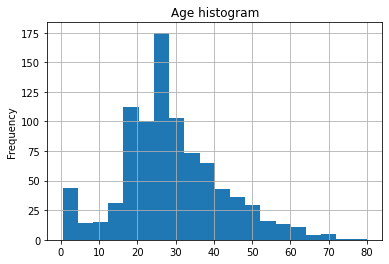

In [20]:
train.Age.plot.hist(bins=20, grid=True, title="Age histogram")

Based on IQR rule, majority of passengers were in 0 to 56. Lots of infants and children, too.

#### Feature Engineering
Try segregating age to answer question: do infants and children have higher chance to live? Do elders have higher chance to die? How old?
##### Method 1: split Age in incrament of 10

In [21]:
def AgeSegmentation(df, seg, col, label=False):
    if label:
        df[col] = pd.cut(df.Age, seg, labels=np.arange(len(seg)-1))
    else:
        df[col] = pd.cut(df.Age, seg)  # skip labels for display purpose

In [22]:
# Method 1: Split Age in incrament of 10
seg = range(0, max(train.Age.values).astype(int)+1, 10)
AgeSegmentation(train, seg, 'AgeSeg')

# Show survival rate of each age segment
display(train.groupby(['AgeSeg']).Survived.describe())

,count,mean,std,min,25%,50%,75%,max
AgeSeg,,,,,,,,
"(0, 10]",68.0,0.588235,0.495812,0.0,0.0,1.0,1.0,1.0
"(10, 20]",148.0,0.425676,0.496124,0.0,0.0,0.0,1.0,1.0
"(20, 30]",323.0,0.291022,0.454938,0.0,0.0,0.0,1.0,1.0
"(30, 40]",193.0,0.424870,0.495609,0.0,0.0,0.0,1.0,1.0
"(40, 50]",95.0,0.431579,0.497924,0.0,0.0,0.0,1.0,1.0
"(50, 60]",42.0,0.404762,0.496796,0.0,0.0,0.0,1.0,1.0
"(60, 70]",17.0,0.235294,0.437237,0.0,0.0,0.0,0.0,1.0
"(70, 80]",5.0,0.200000,0.447214,0.0,0.0,0.0,0.0,1.0


##### Method 2 & 3: Decision Tree
Try finding best splitting points using decision tree:

[Text(441.75, 489.24, 'X[0] <= 6.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(139.5, 380.52000000000004, 'X[0] <= 0.96\ngini = 0.431\nsamples = 51\nvalue = [16, 35]'),
 Text(93.0, 271.8, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(186.0, 271.8, 'X[0] <= 2.5\ngini = 0.463\nsamples = 44\nvalue = [16, 28]'),
 Text(93.0, 163.08000000000004, 'X[0] <= 1.5\ngini = 0.498\nsamples = 17\nvalue = [9, 8]'),
 Text(46.5, 54.360000000000014, 'gini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(139.5, 54.360000000000014, 'gini = 0.42\nsamples = 10\nvalue = [7, 3]'),
 Text(279.0, 163.08000000000004, 'X[0] <= 4.5\ngini = 0.384\nsamples = 27\nvalue = [7, 20]'),
 Text(232.5, 54.360000000000014, 'gini = 0.42\nsamples = 20\nvalue = [6, 14]'),
 Text(325.5, 54.360000000000014, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(744.0, 380.52000000000004, 'X[0] <= 26.5\ngini = 0.464\nsamples = 840\nvalue = [533, 307]'),
 Text(558.0, 271.8, 'X[0] <= 24.25\ngini = 0.431\nsamples = 397\nvalue 

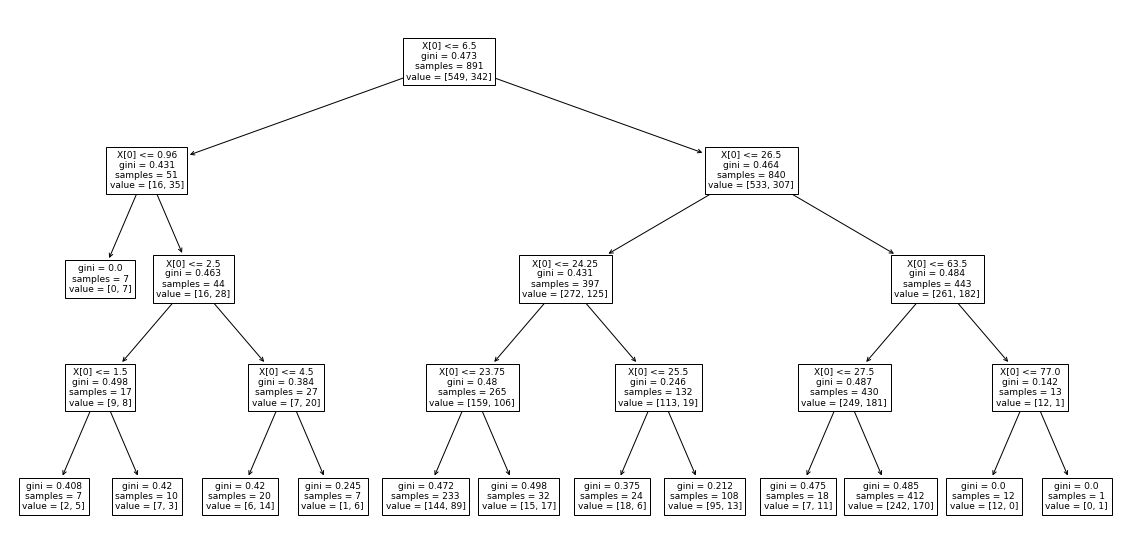

In [23]:
# Fit age to decision tree
plt.figure(figsize=(20, 10))
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(train.Age.values.reshape(-1, 1), train.Survived.values.reshape(-1, 1))
sklearn.tree.plot_tree(clf) 

In [24]:
# Method 2: Use splitting points at 4th split
seg = [0, 1.5, 4.5, 27.5, 30.25, 34.75, 63.5, train.Age.max()]
AgeSegmentation(train, seg, 'AgeSeg4th')

# Show survival rate of each age segment
display(train.groupby(['AgeSeg4th']).Survived.describe())

,count,mean,std,min,25%,50%,75%,max
AgeSeg4th,,,,,,,,
"(0.0, 1.5]",14.0,0.857143,0.363137,0.0,1.0,1.0,1.0,1.0
"(1.5, 4.5]",30.0,0.566667,0.504007,0.0,0.0,1.0,1.0,1.0
"(4.5, 27.5]",422.0,0.336493,0.473071,0.0,0.0,0.0,1.0,1.0
"(27.5, 30.25]",73.0,0.356164,0.482179,0.0,0.0,0.0,1.0,1.0
"(30.25, 34.75]",88.0,0.431818,0.498168,0.0,0.0,0.0,1.0,1.0
"(34.75, 63.5]",251.0,0.422311,0.494914,0.0,0.0,0.0,1.0,1.0
"(63.5, 80.0]",13.0,0.076923,0.277350,0.0,0.0,0.0,0.0,1.0


In [25]:
# Method 3: Pick splitting points with low gini impurity 
seg = [0, 4.5, 30.25, 63.5, train.Age.max()]
AgeSegmentation(train, seg, 'AgeSegGini')

# Show survival rate of each age segment
display(train.groupby(['AgeSegGini']).Survived.describe())

,count,mean,std,min,25%,50%,75%,max
AgeSegGini,,,,,,,,
"(0.0, 4.5]",44.0,0.659091,0.479495,0.0,0.0,1.0,1.0,1.0
"(4.5, 30.25]",495.0,0.339394,0.473983,0.0,0.0,0.0,1.0,1.0
"(30.25, 63.5]",339.0,0.424779,0.495040,0.0,0.0,0.0,1.0,1.0
"(63.5, 80.0]",13.0,0.076923,0.277350,0.0,0.0,0.0,0.0,1.0


In [26]:
# Label all segments
seg = range(0, max(train.Age.values).astype(int)+1, 10)
AgeSegmentation(train, seg, 'AgeSeg', True)
AgeSegmentation(test, seg, 'AgeSeg', True)

seg = [0, 1.5, 4.5, 27.5, 30.25, 34.75, 63.5, train.Age.max()]
AgeSegmentation(train, seg, 'AgeSeg4th', True)
AgeSegmentation(test, seg, 'AgeSeg4th', True)               

seg = [0, 4.5, 30.25, 63.5, train.Age.max()]
AgeSegmentation(train, seg, 'AgeSegGini', True)
AgeSegmentation(test, seg, 'AgeSegGini', True)

Children less than 10 years old have higher survival rate and elders in their 60s or older have lower survival rate. But both segment don't have many instances to begin with.

Keep all 3 methods for now and later we'll use feature selection to eliminate least important method.

### Ticket
Ticket number might have weak direct link with survival rate. We can still extract information and look for any indirect link.

Observed from data:
- Duplicated tickets often have same fare
- Some duplicated tickets are also assigned to same cabin
- Lots of family have same ticket number
- For tickets with only numbers, first digit usually corresponds to Pclass
- For tickets with characters, certain prefix are associated to certain class

In [27]:
# Extract numeric part in ticket number
def ExtractTicketNum(df):
    numbers = []
    for ticket in df.Ticket.values:
        if ticket == "LINE":
            numbers.append(0)
        for subs in ticket.split():
            if subs.isdecimal():
                numbers.append(subs)
                break
    df['TicketNum'] = np.array(numbers, dtype=int)
    
ExtractTicketNum(test)
ExtractTicketNum(train)

### Fare
It's unsure if it's fare per person or fare for family, especially there are cases where a big family (judging from last name,  same ticket number, and same fare) spending unreasonable large sum of fare for 3rd class cabin. Use various methods to analyze Fare and find the method that best correlates with Survived.

But first, some passengers have fare = 0, which is unreasonable:
- Consider replacing 0 with average fare of each class
- Consider replacing missing values with average fare of each class

In [28]:
# Treat fare = 0 as invalid
def ReplaceZeroFare(df):
    df.loc[df.Fare == 0, 'Fare'] = np.NaN

In [29]:
# Fill invalid fare with median fare of each class
def FillFare(df, feature):
    ReplaceZeroFare(df)
    fareDict = dict(train.groupby(['Pclass'])[feature].median())
    df.loc[df[feature].isnull(), feature] = df[df[feature].isnull()].Pclass.map(fareDict)

FillFare(test, 'Fare')
FillFare(train, 'Fare')

In [30]:
# Show statistics of Fare of each class
train.groupby(['Pclass']).Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,85.589391,77.383157,5.0000,33.8906,61.9792,93.5,512.3292
2,184.0,21.152060,12.916284,10.5000,13.0000,15.0229,26.0,73.5000
3,491.0,13.741131,11.723991,4.0125,7.7500,8.0500,15.5,69.5500


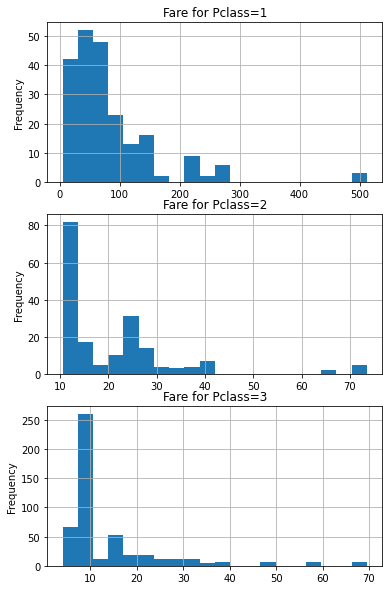

In [31]:
# Plot Fare distribution of each class
plt.figure(figsize=(6,10))
for Pclass in [1,2,3]:
    plt.subplot(3,1,Pclass)
    train[train.Pclass == Pclass].Fare.plot.hist(bins=20, grid=True, title="Fare for Pclass=%d"%Pclass)

#### Feature Engineering
##### Method 1: Fare per Person
Assuming Fare refers to the price for whole family/group, then the fare per person is dividing fare by (SibSp + ParCh + 1(self)). The down side with this calculation is that some families travel with companions (judging by the same ticket number and same cabin) that are not listed in SibSp nor ParCh, or not even in training set. For simplicity, we'll assume those who are not listed as family member are unrelated to the family and traveled alone.

In [32]:
# Find fare per person
def FarePerPerson(df):
    ReplaceZeroFare(df)
    df['FamilySize'] = df.SibSp + df.Parch + 1
    df['FarePerPerson'] = df.Fare / df.FamilySize
    FillFare(df, 'FarePerPerson')

FarePerPerson(train)    
FarePerPerson(test)

In [33]:
# Show statistics of Fare of each class
train.groupby(['Pclass']).FarePerPerson.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,54.371647,60.387566,5.000000,27.50,35.50,54.45,512.3292
2,184.0,13.188709,7.709789,2.875000,10.50,13.00,13.00,73.5000
3,491.0,8.160337,6.287358,1.132143,6.75,7.75,8.05,56.4958


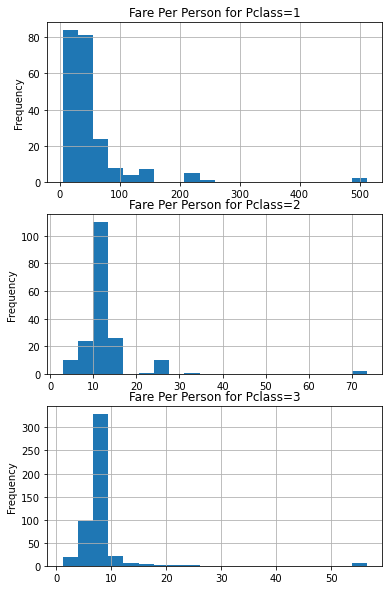

In [34]:
# Plot Fare distribution of each class
plt.figure(figsize=(6,10))
for Pclass in [1,2,3]:
    plt.subplot(3, 1, Pclass)
    train[train.Pclass == Pclass].FarePerPerson.plot.hist(bins=20, grid=True, title="Fare Per Person for Pclass=%d"%Pclass)

##### Method 2: Fare per Ticket
Method 1 assumes that companions who are not family members bought their ticket separately. In this method, we'll try to minimize that assumption by using ticket number. Duplicated ticket number implies that this passenger is part of a group, whether it's family, business partners, friends, etc. The number of duplicated tickets indicates size of the group, thus gives the fare per infividual. Down side of this method is that training set is incomplete and unable to show the real size of all groups. So by combining with method 1, calculation by ticket number covers up the cases people who aren't family members buy tickets together.

In [35]:
def FarePerTicket(df):
    FarePerTicket = []
    for x in range(len(df)):
        dupTickets = df[df.Ticket == df.iloc[x].Ticket]
        groupSize = max(len(dupTickets), df.iloc[x].FamilySize)
        FarePerTicket.append(df.iloc[x].Fare / groupSize)
    df['FarePerTicket'] = FarePerTicket
    
FarePerTicket(test)
FarePerTicket(train)

In [36]:
# Show statistics of Fare of each class
train.groupby(['Pclass']).FarePerTicket.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,39.441989,25.380069,5.000000,26.550000,30.63855,44.550525,221.7792
2,184.0,11.495525,3.056781,2.875000,10.500000,12.76250,13.000000,26.0000
3,491.0,7.172146,1.832308,1.132143,6.614583,7.75000,8.039600,22.5250


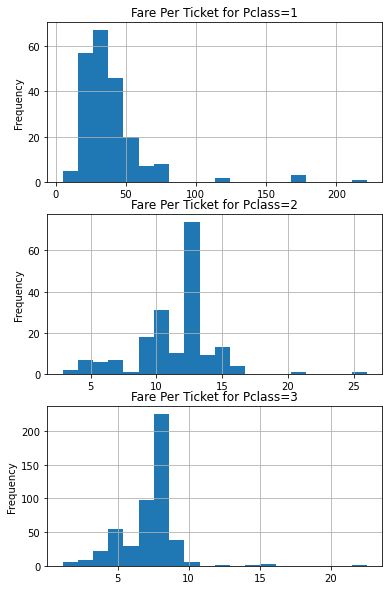

In [37]:
# Plot Fare distribution of each class
plt.figure(figsize=(6,10))
for Pclass in [1,2,3]:
    plt.subplot(3,1,Pclass)
    train[train.Pclass == Pclass].FarePerTicket.plot.hist(bins=20, grid=True, title="Fare Per Ticket for Pclass=%d"%Pclass)

Method 2 using duplicated ticket seems to yield average individual ticket price closest to the actual Titanic ticket price according to [this link](https://autumnmccordckp.weebly.com/tickets-and-accomodations.html#:~:text=Ticket%20Prices%20and%20Accommodations%20on%20Board%20the%20Titanic&text=First%20Class%20Suite%2D%20%C2%A3870,to%20%C2%A38%20or%20%2440):
- First Class Suite- £870
- First Class Berth- £30
- Second Class- £12
- Third Class- £3 to £8

### Cabin
Over half of data don't have cabin number. As mentioned in assumption, incomplete cabin data were recovered and are mostly 1st class cabins. However, we can still make use of the assumption that passengers with cabin data stay in 1st class cabins, and the first character of cabin might link to the location of the cabin on Titanic and thus link to survival rate.

In [38]:
# Extract and label first character of cabin, label with 0 if not exist
def ExtractCabin(train, test):
    # Extract cabin deck, create encoder and transform training set
    train.Cabin.fillna("0", inplace=True)
    cabins = []
    for cabin in train.Cabin:
        if pd.isnull(cabin):
            cabins.append("0")
        else:
            cabins.append(cabin[0])
    encoder = LabelEncoder().fit(cabins)
    train['CabinEncode'] = encoder.transform(cabins)
    
    # Extract cabin deck and transform test set
    test.Cabin.fillna("0", inplace=True)
    cabins = []    
    for cabin in test.Cabin:
        if pd.isnull(cabin):
            cabins.append("0")
        else:
            cabins.append(cabin[0])
    test['CabinEncode'] = encoder.transform(cabins)

ExtractCabin(train, test)

### Embarkation
Without understanding population, house price, characteristics of area, and residents' income level in Cherbourg, Queenstown, and Southampton, I can't relate embarkation to survival rate. 

In [39]:
train.groupby(['Embarked']).Survived.describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,168.0,0.553571,0.498608,0.0,0.0,1.0,1.0,1.0
Q,77.0,0.389610,0.490860,0.0,0.0,0.0,1.0,1.0
S,644.0,0.336957,0.473037,0.0,0.0,0.0,1.0,1.0


One hypothesis is that Cherbourg is a wealthier county and lots of first class passengers boarded from Cherbourg. Other hypothesis is that more women boarded from Cherbourg. We'll look at how Embarked relates survival rate with other features in group statistics.

In [40]:
def EncodeEmbarked(train, test):
    train.Embarked.fillna("S", inplace=True)
    test.Embarked.fillna("S", inplace=True)
    
    encoder = LabelEncoder().fit(train.Embarked)
    train.Embarked = encoder.transform(train.Embarked)
    test.Embarked = encoder.transform(test.Embarked)

EncodeEmbarked(train, test)

In [41]:
def FillEmbarked(df):
    df.Embarked.fillna(train.groupby(['Pclass']).Embarked.mean(), inplace=True)
    
FillEmbarked(train)
FillEmbarked(test)

### Survived
Survived is the target. Notice that our data is imbalanced with more deceased than survived, consider using "balanced_accuracy" instead of "accuracy" metrics.

In [42]:
train.groupby(['Survived']).size()

Survived
0    549
1    342
dtype: int64

### Group Features
Observe how survival rate correlate with multiple features, especially with two strong features: Sex and Pclass.

#### Sex and Pclass
Based on EDA, Sex has the trend of high survival rate for women, and Pclass has trend of high survival rate for 1st class passengers. Let's see if the principle still hold if we combine Sex and Pclass.

In [43]:
# The survival rate of man and women of each class
train.groupby(['Sex', 'Pclass']).Survived.describe()

count      mean       std  min  25%  50%  75%  max
Sex Pclass                                                    
0   1       122.0  0.368852  0.484484  0.0  0.0  0.0  1.0  1.0
    2       108.0  0.157407  0.365882  0.0  0.0  0.0  0.0  1.0
    3       347.0  0.135447  0.342694  0.0  0.0  0.0  0.0  1.0
1   1        94.0  0.968085  0.176716  0.0  1.0  1.0  1.0  1.0
    2        76.0  0.921053  0.271448  0.0  1.0  1.0  1.0  1.0
    3       144.0  0.500000  0.501745  0.0  0.0  0.5  1.0  1.0

Pclass
1    AxesSubplot(0.125,0.125;0.775x0.343182)
2    AxesSubplot(0.125,0.125;0.775x0.343182)
3    AxesSubplot(0.125,0.125;0.775x0.343182)
Name: Survived, dtype: object

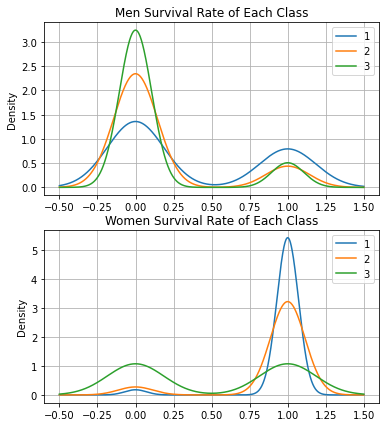

In [44]:
# Plot en and Women survival rate of each class
plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
train[train.Sex==0].groupby(['Pclass']).Survived.plot.density(legend=True, grid=True, xlabel="Class", title="Men Survival Rate of Each Class")
plt.subplot(2,1,2)
train[train.Sex==1].groupby(['Pclass']).Survived.plot.density(legend=True, grid=True, xlabel="Class", title="Women Survival Rate of Each Class")

As expected, the Sex and Pclass principles still hold and together we got women in higher class have highest survival rate, and men in lower class have worst survival rate:
- 1st class women > 2nd class women > 3rd class women > 1st class men > 2nd class men > 3rd class men

Create a feature to capture this ranking:

In [45]:
# Add new group feature: mean of survival rate of men and women of each class
SexClassDict = dict(train.groupby(['Sex', 'Pclass']).Survived.mean())

train['SexClass'] = [SexClassDict[tuple(group)] for group in train[['Sex', 'Pclass']].values]
train.SexClass.fillna(train.SexClass.mean(), inplace=True)

avg = train.SexClass.mean()
col = []
for group in test[['Sex', 'Pclass']].values:
    if tuple(group) in SexClassDict:
        col.append(SexClassDict[tuple(group)])
    else:
        col.append(avg)
test['SexClass'] = col

#### Sex and Pclass and Age
See if age distribution of each class of each sex links to survival rate.

Pclass
1    AxesSubplot(0.125,0.125;0.775x0.343182)
2    AxesSubplot(0.125,0.125;0.775x0.343182)
3    AxesSubplot(0.125,0.125;0.775x0.343182)
Name: Age, dtype: object

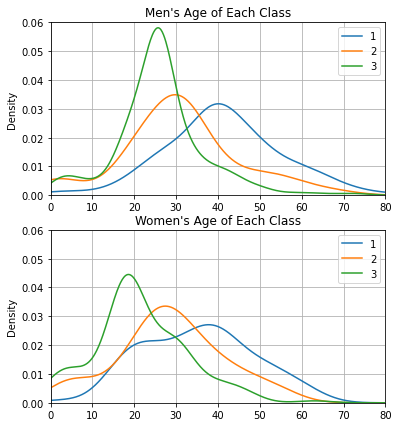

In [46]:
# Plot men and Women's age of each class
plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
train[train.Sex==0].groupby(['Pclass']).Age.plot.density(legend=True, grid=True, xlim=(0,80), ylim=(0,0.06), title="Men's Age of Each Class")
plt.subplot(2,1,2)
train[train.Sex==1].groupby(['Pclass']).Age.plot.density(legend=True, grid=True, xlim=(0,80), ylim=(0,0.06), title="Women's Age of Each Class")

Age distribution:
- In general, men on board were older than women
- In general, higher class are older than lower class
- 1st class men in general are slightly older than women
- 2nd class men and women generally have the same age
- 3rd class men in general are older than women
- Most 1st class men are between 20 to mid-60s, majority are around 40
- Most 1st class women are between early 10s to 60, majority are around late 30s
- Most 2nd class men are between mid-10s to mid-50s, majority are around 30
- Most 2nd class women are between 10 to 50, majority are around late 20s
- Most 3rd class men are betweenearly 10s to 40s, majority are around mid-20s
- Most 3rd class women are between 0 to 40, majority are around late 10s

In [47]:
display(train.groupby(['Sex', 'Pclass', 'AgeSeg']).Survived.describe())

count      mean       std  min  25%  50%   75%  max
Sex Pclass AgeSeg                                                     
0   1      0         2.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           1         5.0  0.400000  0.547723  0.0  0.0  0.0  1.00  1.0
           2        19.0  0.473684  0.512989  0.0  0.0  0.0  1.00  1.0
           3        45.0  0.400000  0.495434  0.0  0.0  0.0  1.00  1.0
           4        25.0  0.360000  0.489898  0.0  0.0  0.0  1.00  1.0
           5        14.0  0.285714  0.468807  0.0  0.0  0.0  0.75  1.0
           6         9.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
           7         3.0  0.333333  0.577350  0.0  0.0  0.0  0.50  1.0
    2      0         9.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           1        10.0  0.100000  0.316228  0.0  0.0  0.0  0.00  1.0
           2        33.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
           3        35.0  0.142857  0.355036  0.0  0.0  0.0  0.00  1.0
           4         9.0  0.111111  0.333333  0.0  0.0  0.0  0.00  1.0
           5         9.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
           6         3.0  0.333333  0.577350  0.0  0.0  0.0  0.50  1.0
    3      0        26.0  0.384615  0.496139  0.0  0.0  0.0  1.00  1.0
           1        54.0  0.129630  0.339050  0.0  0.0  0.0  0.00  1.0
           2       187.0  0.112299  0.316582  0.0  0.0  0.0  0.00  1.0
           3        49.0  0.142857  0.353553  0.0  0.0  0.0  0.00  1.0
           4        22.0  0.090909  0.294245  0.0  0.0  0.0  0.00  1.0
           5         5.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
           6         2.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
           7         2.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
1   1      0         1.0  0.000000       NaN  0.0  0.0  0.0  0.00  0.0
           1        13.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           2        22.0  0.954545  0.213201  0.0  1.0  1.0  1.00  1.0
           3        24.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           4        21.0  0.952381  0.218218  0.0  1.0  1.0  1.00  1.0
           5        11.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           6         2.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
    2      0         8.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           1         8.0  1.000000  0.000000  1.0  1.0  1.0  1.00  1.0
           2        30.0  0.900000  0.305129  0.0  1.0  1.0  1.00  1.0
           3        17.0  0.941176  0.242536  0.0  1.0  1.0  1.00  1.0
           4        10.0  0.900000  0.316228  0.0  1.0  1.0  1.00  1.0
           5         3.0  0.666667  0.577350  0.0  0.5  1.0  1.00  1.0
    3      0        22.0  0.500000  0.511766  0.0  0.0  0.5  1.00  1.0
           1        58.0  0.551724  0.501661  0.0  0.0  1.0  1.00  1.0
           2        32.0  0.500000  0.508001  0.0  0.0  0.5  1.00  1.0
           3        23.0  0.521739  0.510754  0.0  0.0  1.0  1.00  1.0
           4         8.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
           6         1.0  1.000000       NaN  1.0  1.0  1.0  1.00  1.0

- Men have low survival rate
- Boys and infants have higher survival rate
- 1st class men under 50 have relatively higher survival rate
- 2nd and 3rd class men over 10 were almost all dead
- 1st and 2nd class women were almost all saved
- 3rd class women at 40s or above have low survival rate
- 3rd class women have 50% survival rate

Create a feature to capture the observations:

In [48]:
SexClassAgeDict = dict(train.groupby(['Sex', 'Pclass', 'AgeSeg']).Survived.mean())

train['SexClassAge'] = [SexClassAgeDict[tuple(group)] for group in train[['Sex', 'Pclass', 'AgeSeg']].values]
train.SexClassAge.fillna(train.SexClassAge.mean(), inplace=True)

avg = train.SexClassAge.mean()
col = []
for group in test[['Sex', 'Pclass', 'AgeSeg']].values:
    if tuple(group) in SexClassAgeDict:
        col.append(SexClassAgeDict[tuple(group)])
    else:
        col.append(avg)
test['SexClassAge'] = col
test.SexClassAge.fillna(0, inplace=True)

#### Sex and Pclass and Title

In [49]:
display(train.groupby(['Sex', 'Pclass', 'TitleGroup']).Survived.describe())

count      mean       std  min  25%  50%  75%  max
Sex Pclass TitleGroup                                                    
0   1      3             3.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
           5           114.0  0.350877  0.479352  0.0  0.0  0.0  1.0  1.0
           6             5.0  0.400000  0.547723  0.0  0.0  0.0  1.0  1.0
    2      3             9.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
           5            93.0  0.086022  0.281916  0.0  0.0  0.0  0.0  1.0
           6             6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
    3      3            28.0  0.392857  0.497347  0.0  0.0  0.0  1.0  1.0
           5           319.0  0.112853  0.316910  0.0  0.0  0.0  0.0  1.0
1   1      1             2.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
           2            44.0  0.977273  0.150756  0.0  1.0  1.0  1.0  1.0
           4            48.0  0.958333  0.201941  0.0  1.0  1.0  1.0  1.0
    2      2            41.0  0.902439  0.300406  0.0  1.0  1.0  1.0  1.0
           4            35.0  0.942857  0.235504  0.0  1.0  1.0  1.0  1.0
    3      2            42.0  0.500000  0.506061  0.0  0.0  0.5  1.0  1.0
           4           102.0  0.500000  0.502469  0.0  0.0  0.5  1.0  1.0

In [50]:
SexClassTitleDict = dict(train.groupby(['Sex', 'Pclass', 'TitleGroup']).Survived.mean())

train['SexClassTitle'] = [SexClassTitleDict[tuple(group)] for group in train[['Sex', 'Pclass', 'TitleGroup']].values]
train.SexClassTitle.fillna(train.SexClassTitle.mean(), inplace=True)

avg = train.SexClassTitle.mean()
col = []
for group in test[['Sex', 'Pclass', 'TitleGroup']].values:
    if tuple(group) in SexClassTitleDict:
        col.append(SexClassTitleDict[tuple(group)])
    else:
        col.append(avg)
test['SexClassTitle'] = col
test.SexClassTitle.fillna(0, inplace=True)

#### Sex and Pclass and Spouse/Siblings

In [51]:
display(train.groupby(['Sex', 'Pclass', 'SibSp']).Survived.describe())

count      mean       std  min   25%  50%   75%  max
Sex Pclass SibSp                                                      
0   1      0       88.0  0.329545  0.472742  0.0  0.00  0.0  1.00  1.0
           1       31.0  0.483871  0.508001  0.0  0.00  0.0  1.00  1.0
           2        2.0  0.500000  0.707107  0.0  0.25  0.5  0.75  1.0
           3        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
    2      0       76.0  0.118421  0.325253  0.0  0.00  0.0  0.00  1.0
           1       27.0  0.259259  0.446576  0.0  0.00  0.0  0.50  1.0
           2        5.0  0.200000  0.447214  0.0  0.00  0.0  0.00  1.0
    3      0      270.0  0.129630  0.336519  0.0  0.00  0.0  0.00  1.0
           1       45.0  0.222222  0.420437  0.0  0.00  0.0  0.00  1.0
           2        8.0  0.125000  0.353553  0.0  0.00  0.0  0.00  1.0
           3        4.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
           4       12.0  0.083333  0.288675  0.0  0.00  0.0  0.00  1.0
           5        4.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
           8        4.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
1   1      0       49.0  0.979592  0.142857  0.0  1.00  1.0  1.00  1.0
           1       40.0  0.950000  0.220721  0.0  1.00  1.0  1.00  1.0
           2        3.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
           3        2.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
    2      0       44.0  0.931818  0.254972  0.0  1.00  1.0  1.00  1.0
           1       28.0  0.892857  0.314970  0.0  1.00  1.0  1.00  1.0
           2        3.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
           3        1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0
    3      0       81.0  0.592593  0.494413  0.0  0.00  1.0  1.00  1.0
           1       38.0  0.447368  0.503897  0.0  0.00  0.0  1.00  1.0
           2        7.0  0.571429  0.534522  0.0  0.00  1.0  1.00  1.0
           3        8.0  0.125000  0.353553  0.0  0.00  0.0  0.00  1.0
           4        6.0  0.333333  0.516398  0.0  0.00  0.0  0.75  1.0
           5        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
           8        3.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0

In [52]:
SexClassSibSpDict = dict(train.groupby(['Sex', 'Pclass', 'SibSp']).Survived.mean())

train['SexClassSibSp'] = [SexClassSibSpDict[tuple(group)] for group in train[['Sex', 'Pclass', 'SibSp']].values]
train.SexClassSibSp.fillna(train.SexClassSibSp.mean(), inplace=True)

avg = train.SexClassSibSp.mean()
col = []
for group in test[['Sex', 'Pclass', 'SibSp']].values:
    if tuple(group) in SexClassSibSpDict:
        col.append(SexClassSibSpDict[tuple(group)])
    else:
        col.append(avg)
test['SexClassSibSp'] = col

#### Sex and Pclass and Parent/Children

In [53]:
display(train.groupby(['Sex', 'Pclass', 'Parch']).Survived.describe())

count      mean       std  min   25%  50%   75%  max
Sex Pclass Parch                                                      
0   1      0       99.0  0.363636  0.483494  0.0  0.00  0.0  1.00  1.0
           1       14.0  0.285714  0.468807  0.0  0.00  0.0  0.75  1.0
           2        8.0  0.625000  0.517549  0.0  0.00  1.0  1.00  1.0
           4        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
    2      0       89.0  0.089888  0.287641  0.0  0.00  0.0  0.00  1.0
           1       14.0  0.500000  0.518875  0.0  0.00  0.5  1.00  1.0
           2        5.0  0.400000  0.547723  0.0  0.00  0.0  1.00  1.0
    3      0      296.0  0.121622  0.327402  0.0  0.00  0.0  0.00  1.0
           1       30.0  0.266667  0.449776  0.0  0.00  0.0  0.75  1.0
           2       18.0  0.166667  0.383482  0.0  0.00  0.0  0.00  1.0
           3        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
           4        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
           5        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
1   1      0       64.0  0.984375  0.125000  0.0  1.00  1.0  1.00  1.0
           1       17.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
           2       13.0  0.846154  0.375534  0.0  1.00  1.0  1.00  1.0
    2      0       45.0  0.888889  0.317821  0.0  1.00  1.0  1.00  1.0
           1       18.0  0.944444  0.235702  0.0  1.00  1.0  1.00  1.0
           2       11.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
           3        2.0  1.000000  0.000000  1.0  1.00  1.0  1.00  1.0
    3      0       85.0  0.588235  0.495074  0.0  0.00  1.0  1.00  1.0
           1       25.0  0.480000  0.509902  0.0  0.00  0.0  1.00  1.0
           2       25.0  0.320000  0.476095  0.0  0.00  0.0  1.00  1.0
           3        2.0  0.500000  0.707107  0.0  0.25  0.5  0.75  1.0
           4        2.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
           5        4.0  0.250000  0.500000  0.0  0.00  0.0  0.25  1.0
           6        1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0

In [54]:
SexClassParchDict = dict(train.groupby(['Sex', 'Pclass', 'Parch']).Survived.mean())

train['SexClassParch'] = [SexClassParchDict[tuple(group)] for group in train[['Sex', 'Pclass', 'Parch']].values]
train.SexClassParch.fillna(train.SexClassParch.mean(), inplace=True)

avg = train.SexClassParch.mean()
col = []
for group in test[['Sex', 'Pclass', 'Parch']].values:
    if tuple(group) in SexClassParchDict:
        col.append(SexClassParchDict[tuple(group)])
    else:
        col.append(avg)
test['SexClassParch'] = col

#### Sex and Pclass and Embarked
Previously when we only look at survival rate based on embarked location, Cherbourg had highest survival rate. One hypothesis is that Cherbourg is a wealthier county and lots of first class passengers boarded from Cherbourg. Other hypothesis is that more women boarded from Cherbourg. Here we'll try to prove the hypothesis from group statistics:
- Cherbourg = 0
- Queenstown = 1
- Southampton = 2

In [55]:
# The survival rate of man and women of each class
train.groupby(['Embarked', 'Pclass', 'Sex']).Survived.describe()

count      mean       std  min  25%  50%  75%  max
Embarked Pclass Sex                                                    
0        1      0     42.0  0.404762  0.496796  0.0  0.0  0.0  1.0  1.0
                1     43.0  0.976744  0.152499  0.0  1.0  1.0  1.0  1.0
         2      0     10.0  0.200000  0.421637  0.0  0.0  0.0  0.0  1.0
                1      7.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
         3      0     43.0  0.232558  0.427463  0.0  0.0  0.0  0.0  1.0
                1     23.0  0.652174  0.486985  0.0  0.0  1.0  1.0  1.0
1        1      0      1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
                1      1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0
         2      0      1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
                1      2.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
         3      0     39.0  0.076923  0.269953  0.0  0.0  0.0  0.0  1.0
                1     33.0  0.727273  0.452267  0.0  0.0  1.0  1.0  1.0
2        1      0     79.0  0.354430  0.481397  0.0  0.0  0.0  1.0  1.0
                1     50.0  0.960000  0.197949  0.0  1.0  1.0  1.0  1.0
         2      0     97.0  0.154639  0.363439  0.0  0.0  0.0  0.0  1.0
                1     67.0  0.910448  0.287694  0.0  1.0  1.0  1.0  1.0
         3      0    265.0  0.128302  0.335058  0.0  0.0  0.0  0.0  1.0
                1     88.0  0.375000  0.486897  0.0  0.0  0.0  1.0  1.0

We're at the correct direction! Half of passengers embarked at Cherbourg were first class passengers and 43% were women, which make sense that people embarked at Cherbourg had higher survival rate.

Here's the observation:
- Passengers from Cherbourg were 43.5% women
- Passengers from Queenstown were 46.7% women
- Passengers from Southampton were 31.7% women
- Passengers from Cherbourg were 50.6% 1st class, 10% 2nd class, 39.3% 3rd class
- Passengers from Queenstown were 2.6% 1st class, 3.9% 2nd class, 93.5% 3rd class
- Passengers from Southampton were 20.0% 1st class, 25.4% 2nd class, 54.6% 3rd class
- Men and women passengers from Cherbourg have relatively higher survival rate compare to other locations
- 3rd class from Southampton has worst survival rate compare to other 3rd class passengers from other locations
- Total 5 1st and 2nd class passengers boarded from Queenstown
    - Consider replace with average of Cherbourg and Southampton 1st and 2nd class survival rate

Create a feature to capture this statistics:

In [56]:
# Create dictionary of survival rate of each sex, class, and embarked location
SexClassEmbarkDict = dict(train.groupby(['Sex', 'Pclass', 'Embarked']).Survived.mean())

# Replace survival rate of 1st and 2nd class men and women at Queenstown (Embarked = 1) with 
# mean of Cherbourg (Embarked = 0) and Southampton (Embarked = 2)
for (sex, pclass) in [(0, 1), (0, 2), (1, 1), (1, 2)]:
    SexClassEmbarkDict[(sex, pclass, 1)] = np.mean([SexClassEmbarkDict[(sex, pclass, 0)], SexClassEmbarkDict[(sex, pclass, 2)]])

In [57]:
train['SexClassEmbark'] = [SexClassEmbarkDict[tuple(group)] for group in train[['Sex', 'Pclass', 'Embarked']].values]
train.SexClassEmbark.fillna(train.SexClassEmbark.mean(), inplace=True)

avg = train.SexClassEmbark.mean()
col = []
for group in test[['Sex', 'Pclass', 'Embarked']].values:
    if tuple(group) in SexClassEmbarkDict:
        col.append(SexClassEmbarkDict[tuple(group)])
    else:
        col.append(avg)
test['SexClassEmbark'] = col

### Features Correlation

<AxesSubplot:>

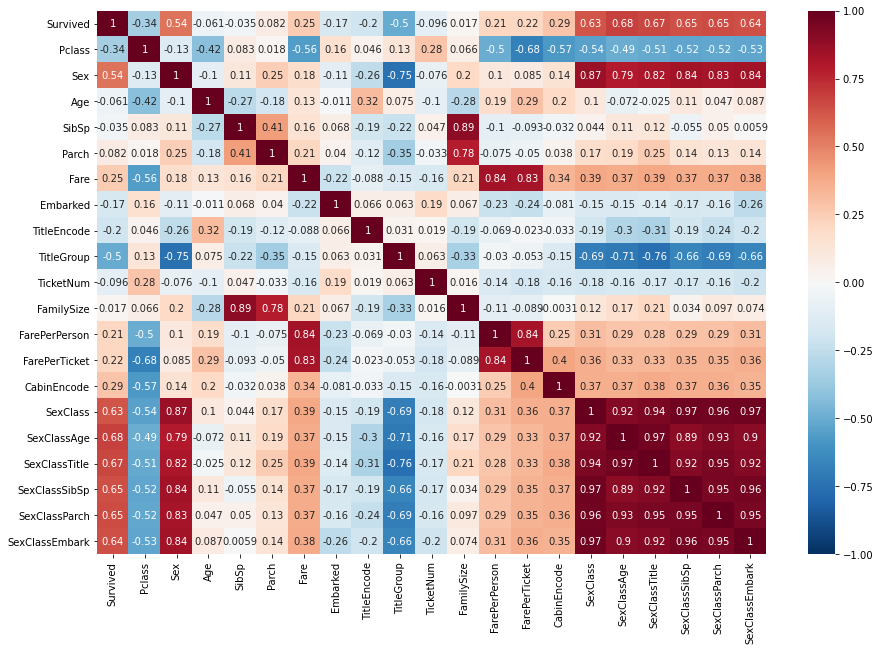

In [58]:
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), annot=True, vmin=-1, cmap="RdBu_r")

### Feature Selection
Use GradientBoostClassifier, RandomForestClassifier, ExtraTreeClassifier, and RFE (Recursive Feature Elimination) to select top features.

In [59]:
tmp_X = train.drop(columns=['Name', 'Ticket', 'Cabin', 'Title', 'Survived'])
tmp_y = train.Survived

# create feature selection dataframe to store scores
feat_sel = pd.DataFrame(index=tmp_X.columns)

In [60]:
# use ensemble models to find feature importance
def add_feat_sel(model, name):
    model.fit(tmp_X, tmp_y)
    feat_sel[name] = model.feature_importances_
    feat_sel[name+"_rank"] = feat_sel[name].rank(ascending=False)

add_feat_sel(GradientBoostingClassifier(), "GBC")
add_feat_sel(RandomForestClassifier(), "RFC")
add_feat_sel(ExtraTreesClassifier(), "ETC")

In [61]:
# use RFE to rank feature importance
model = GradientBoostingClassifier()
rfe = RFE(model, n_features_to_select=1)
score = rfe.fit(tmp_X, tmp_y)
feat_sel["RFE"] = score.ranking_

In [62]:
# find total rank
feat_sel["sum"] = sum([feat_sel["GBC_rank"], feat_sel["RFC_rank"], feat_sel["ETC_rank"], feat_sel["RFE"]])
feat_sel["sum_rank"] = feat_sel["sum"].rank()

In [63]:
feat_sel

,GBC,GBC_rank,RFC,RFC_rank,ETC,ETC_rank,RFE,sum,sum_rank
Pclass,0.000023,21.0,0.006337,22.0,0.013447,21.0,22,86.0,22.0
Sex,0.000000,23.0,0.033230,12.0,0.043087,12.0,20,67.0,17.0
Age,0.026600,9.0,0.071143,6.0,0.065694,6.0,8,29.0,6.0
SibSp,0.002053,16.0,0.014829,19.0,0.017231,18.0,14,67.0,17.0
Parch,0.000021,22.0,0.005831,23.0,0.007995,23.0,19,87.0,23.0
Fare,0.035114,7.0,0.063528,8.0,0.059847,9.0,5,29.0,6.0
Embarked,0.000282,18.0,0.011286,20.0,0.015280,19.0,23,80.0,21.0
TitleEncode,0.003881,14.0,0.015739,18.0,0.013650,20.0,15,67.0,17.0
TitleGroup,0.007701,12.0,0.040087,11.0,0.028969,13.0,11,47.0,12.0
AgeSeg,0.000221,19.0,0.018841,17.0,0.019961,16.0,17,69.0,19.0


In [64]:
# top 10 on feature selection ranking
feat_sel[feat_sel.sum_rank.le(10)]

,GBC,GBC_rank,RFC,RFC_rank,ETC,ETC_rank,RFE,sum,sum_rank
Age,0.026600,9.0,0.071143,6.0,0.065694,6.0,8,29.0,6.0
Fare,0.035114,7.0,0.063528,8.0,0.059847,9.0,5,29.0,6.0
TicketNum,0.093059,3.0,0.113173,1.0,0.099324,1.0,3,8.0,1.5
FarePerPerson,0.033332,8.0,0.059615,10.0,0.060504,8.0,4,30.0,8.0
FarePerTicket,0.046300,4.0,0.061928,9.0,0.056839,10.0,6,29.0,6.0
SexClassAge,0.348006,1.0,0.087695,2.0,0.081774,3.0,2,8.0,1.5
SexClassTitle,0.008689,11.0,0.064397,7.0,0.073106,4.0,10,32.0,9.0
SexClassSibSp,0.038294,6.0,0.079971,3.0,0.062852,7.0,9,25.0,4.0
SexClassParch,0.004600,13.0,0.074892,5.0,0.090355,2.0,13,33.0,10.0
SexClassEmbark,0.299280,2.0,0.078206,4.0,0.068456,5.0,1,12.0,3.0


Following are top 10 features most frquently picked by feature selecting methods shown above, we'll keep these features and drop rest:
- Age
- Fare
- TicketNum
- FarePerPerson
- FarePerTicket
- SexClassAge
- SexClassTitle
- SexClassSibSp
- SexClassEmbark

In [65]:
selected_features = list(feat_sel[feat_sel.sum_rank.le(11)].index)
display(selected_features)

['Age',
 'Fare',
 'TicketNum',
 'FamilySize',
 'FarePerPerson',
 'FarePerTicket',
 'SexClassAge',
 'SexClassTitle',
 'SexClassSibSp',
 'SexClassParch',
 'SexClassEmbark']

In [66]:
test_filtered = test[selected_features]
selected_features.append('Survived')
train_filtered = train[selected_features]

<AxesSubplot:>

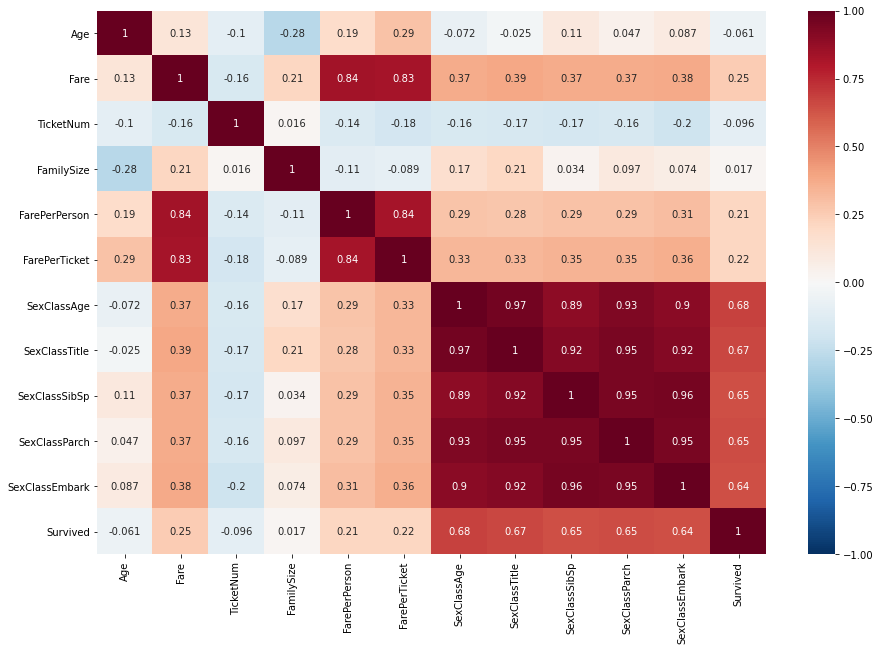

In [67]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_filtered.corr(), annot=True, vmin=-1, cmap="RdBu_r")

## Modeling

### Vanilla Models
First train with vanilla models without tuning any hyperparameter and then select top models for further tuning. Here are some classification models and ensemble models.

In [68]:
model_list = [('LR', LogisticRegression(random_state=10)),
              ('LDA', LinearDiscriminantAnalysis()),
              ('KNN', KNeighborsClassifier()),
              ('NB', GaussianNB()),
              ('SVC', SVC(random_state=10)), 
              ('CART', DecisionTreeClassifier(random_state=10)),
              ## Boosting
              ('AB', AdaBoostClassifier(random_state=10)), 
              ('GB', GradientBoostingClassifier(random_state=10)), 
              ## Bagging
              ('RF', RandomForestClassifier(random_state=10)), 
              ('ET', ExtraTreesClassifier(random_state=10))]

for name, model in model_list:
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, train_filtered.drop(columns='Survived'), train_filtered.Survived, cv=cv, scoring='accuracy')
    print("%s:\tacc=%.6f" % (name, -1.0 * np.mean(scores)))

LR:	acc=-0.627403
LDA:	acc=-0.821548
KNN:	acc=-0.703683
NB:	acc=-0.654407
SVC:	acc=-0.616167
CART:	acc=-0.782335
AB:	acc=-0.833920
GB:	acc=-0.845119
RF:	acc=-0.839538
ET:	acc=-0.823808


### Standardize Data
Train models with standardized data. The result doesn't improve much.

In [69]:
model_list = [('LR', LogisticRegression(random_state=10)),
              ('LDA', LinearDiscriminantAnalysis()),
              ('KNN', KNeighborsClassifier()),
              ('NB', GaussianNB()),
              ('SVC', SVC(random_state=10)), 
              ('CART', DecisionTreeClassifier(random_state=10)),
              ## Boosting
              ('AB', AdaBoostClassifier(random_state=10)), 
              ('GB', GradientBoostingClassifier(random_state=10)), 
              ## Bagging
              ('RF', RandomForestClassifier(random_state=10)), 
              ('ET', ExtraTreesClassifier(random_state=10))]

for name, model in model_list:
    scaled_model = Pipeline([("Scaler", StandardScaler()), (name, model)])
    cv = StratifiedKFold(n_splits=10)
    scores = cross_val_score(model, train_filtered.drop(columns='Survived'), train_filtered.Survived, cv=cv, scoring='accuracy')
    print("%s:\tacc=%.6f" % ("scaled_"+name, -1.0 * np.mean(scores)))

scaled_LR:	acc=-0.627403
scaled_LDA:	acc=-0.821548
scaled_KNN:	acc=-0.703683
scaled_NB:	acc=-0.654407
scaled_SVC:	acc=-0.616167
scaled_CART:	acc=-0.782335
scaled_AB:	acc=-0.833920
scaled_GB:	acc=-0.845119
scaled_RF:	acc=-0.839538
scaled_ET:	acc=-0.823808


### Tune Models
From vanilla models testing, GradientBoostClassifier and RandomForestClassifier have highest accuracy. Perform grid search to find best hyperparameters.
#### Grid Search GradientBoostingClassifier

In [70]:
grid_search = dict(n_estimators = [50, 70, 90, 100],
                   criterion = ['friedman_mse', 'mse'],
                   loss = ['deviance'])
cv = StratifiedKFold(n_splits=10)
grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=10), param_grid=grid_search, scoring='accuracy', cv=cv)
grid_result = grid.fit(train_filtered.drop(columns='Survived'), train_filtered.Survived)

print(grid_result.best_score_, grid_result.best_params_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(mean, stdev, param)

0.8484893882646691 {'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 90}
0.8350312109862671 0.03951259385148478 {'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 50}
0.8417602996254681 0.044467276955741326 {'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 70}
0.8484893882646691 0.04471376827530172 {'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 90}
0.8451186017478152 0.04167305846694104 {'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 100}
0.8350312109862671 0.03951259385148478 {'criterion': 'mse', 'loss': 'deviance', 'n_estimators': 50}
0.8417602996254681 0.044467276955741326 {'criterion': 'mse', 'loss': 'deviance', 'n_estimators': 70}
0.8484893882646691 0.04471376827530172 {'criterion': 'mse', 'loss': 'deviance', 'n_estimators': 90}
0.8451186017478152 0.04167305846694104 {'criterion': 'mse', 'loss': 'deviance', 'n_estimators': 100}


#### Best GradientBoostingClassifier model and Prediction

In [71]:
model = GradientBoostingClassifier(n_estimators=90, criterion="friedman_mse", loss="deviance", random_state=10)
model.fit(train_filtered.drop(columns='Survived'), train_filtered.Survived)
test_pred = pd.DataFrame(model.predict(test_filtered), index=test_filtered.index, columns=["Survived"])
test_pred.to_csv("test_pred_GBC.csv")

#### Grid Search RandomForestClassifier

In [72]:
grid_search = dict(n_estimators=[10, 20, 30, 50],
                   criterion=["gini"],
                   max_depth=[6, 8, 10])
cv = StratifiedKFold(n_splits=10)
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=10), param_grid=grid_search, scoring='accuracy', cv=cv)
grid_result = grid.fit(train_filtered.drop(columns='Survived'), train_filtered.Survived)

print(grid_result.best_score_, grid_result.best_params_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(mean, stdev, param)

0.8507990012484393 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 30}
0.8260923845193509 0.04502022220153323 {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 10}
0.8316978776529338 0.04718448620248427 {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 20}
0.8317103620474408 0.04997439342058705 {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 30}
0.8361922596754058 0.05418740518900777 {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 50}
0.8350561797752809 0.050601233060809214 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 10}
0.8485393258426965 0.046154480620009875 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 20}
0.8507990012484393 0.04405489517890315 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 30}
0.8485642946317103 0.053374400298180885 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 50}
0.8350686641697876 0.05820230744384929 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 10}
0.8418227215980025 0.054621330439214945 {'crit

#### Best RandomForestClassifier model and Prediction

In [73]:
model = RandomForestClassifier(n_estimators=30, criterion="gini", max_depth=8, random_state=10)
model.fit(train_filtered.drop(columns='Survived'), train_filtered.Survived)
test_pred = pd.DataFrame(model.predict(test_filtered), index=test_filtered.index, columns=["Survived"])
test_pred.to_csv("test_pred_RFC.csv")

### XGBoost Model

In [74]:
x_train, x_valid, y_train, y_valid = train_test_split(train_filtered.drop(columns='Survived'), 
                                                      train_filtered.Survived.values, 
                                                      test_size=0.2, 
                                                      random_state=10)
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

params = {'objective':'binary:logistic',
          'max_depth':15,
          'learning_rate':0.14,
          'eval_metric':'auc',
          'min_child_weight':1,
          'subsample':0.65,
          'colsample_bytree':0.4,
          'seed':29,
          'reg_lambda':2.8,
          'reg_alpha':0.09,
          'gamma':0,
          'scale_pos_weight':1,
          'n_estimators': 600,
          'nthread':-1}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000  
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=400, maximize=True, verbose_eval=50)

[0]	train-auc:0.858511	valid-auc:0.872691
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 400 rounds.
[50]	train-auc:0.973607	valid-auc:0.930108
[100]	train-auc:0.991448	valid-auc:0.917701
[150]	train-auc:0.996077	valid-auc:0.914254
[200]	train-auc:0.997846	valid-auc:0.913841
[250]	train-auc:0.998954	valid-auc:0.911084
[300]	train-auc:0.99921	valid-auc:0.910946
[350]	train-auc:0.999351	valid-auc:0.907637
[400]	train-auc:0.999549	valid-auc:0.907913
Stopping. Best iteration:
[42]	train-auc:0.96856	valid-auc:0.934795



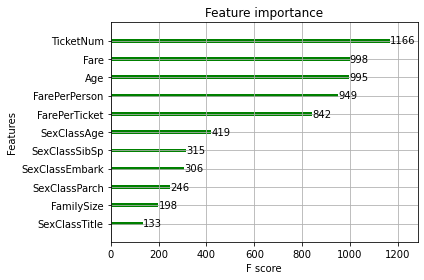

In [75]:
fig,ax = plt.subplots()
xgb.plot_importance(model, ax=ax, color='g')
plt.tight_layout()
plt.show()

#### Prediction

In [76]:
d_test = xgb.DMatrix(test_filtered)
prediction = model.predict(d_test)
test_pred = pd.DataFrame(np.where(prediction > 0.5, 1, 0), index=test_filtered.index, columns=["Survived"])
test_pred.to_csv("test_pred_XGB.csv")